
# Lab 9 - NETCONF : Network Configuration Protocol


University of Colorado Boulder
Dept. of Computer Science

Professor Levi Perigo, Ph.D.


# Summary

The Network Configuration Protocol (NETCONF) provides mechanisms to install, manipulate, and delete the configuration of network devices. It is a standard defined by IETF RFC 6241. YANG is its data modeling language. NETCONF aims to help remove the time, cost and manual steps involved in network elements configuration. The objective of this lab is to provide an overview of NETCONF and its operations.
Students are encouraged to expand on the topics for additional learning and experiments.


# Objective 1: Getting started
# Problem Statement:

1. Create the below topology in GNS3 on the NetMan VM. 
2. Please use the router image c7200-15.2 image for this lab. 

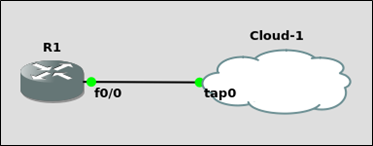

3. Refer this link to configure NETCONF over SSH on the router - https://www.cisco.com/c/en/us/td/docs/ios-xml/ios/cns/configuration/15-mt/cns-15-mt-book/netconf-sshv2.html
Apart from SSH, which other secure transport methods are supported by NETCONF? [5 points]

4. Establish a NETCONF session with the router. Paste screenshots of the commands – show netconf session and show netconf counters on the router indicating a successful NETCONF session. [20 points]

5. Using NETCONF <get-config> message, get the current running configuration of the router. Paste screenshots of the messages. [5 points] [https://www.cisco.com/c/en/us/td/docs/ios-xml/ios/cns/configuration/xe-3s/cns-xe-3s-book/cns-netconf.html]

6. Using NETCONF, get the name of the interfaces on the router. Paste screenshots of the messages. [5 points]

7. Using NETCONF, get the running configuration of the interface FastEthernet1/0. Paste screenshots of the messages. [5 points]

8. Using NETCONF-
a. Set the hostname of the router to – Lab9Router,
b. Create a Loopback Interface 10, and
c. Assign the IP address 10.1.1.1/32 to the interface.
Paste screenshots of the messages. [10 points]

9. Using NETCONF <get> message, get the running configuration of the interface Loopback 10. Paste screenshots of the messages. [5 points]

10. Using NETCONF, copy the running-config to startup-config. Paste screenshots of the messages. [5 points]

11. How do you check if the router supports candidate configuration datastore? Does this router support it? [5 points]

# Objective 2: NETCONF and Python

[ncclient](https://pypi.org/project/ncclient/) is a Python library for NETCONF clients. It offers an intuitive API and makes writing network management scripts easier.

1. Create the below topology in GNS3-

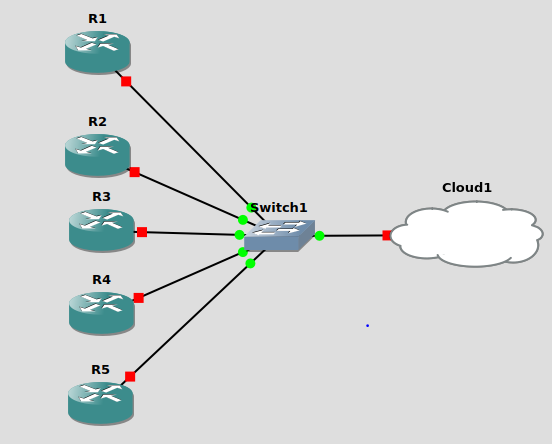

2. The configuration to be implemented is present in the file 'lab9-obj2-conf.csv' (It is present in this directory).
3. The objective is to implement the configuration using a Python script and the ncclient library.
4. Only manual configurations that need to be done are configuring management IPs (198.51.100.11-198.51.100.15) and enabling netconf over SSH (username:lab, password:lab123, with privileged EXEC mode).
5. Implement this objective using the shortest (i.e. the most automated) method you can think of. You can use your own CSV file (with the similar configs) or the provided csv file itself. Please submit the CSV file if it is created by you. Please mention what you are using. 
6. The final output should be a table printed out, as shown in the csv config file, with the details fetched from the routers.
7. Mention the steps you followed to complete this objective in the below cell. 


In [3]:
import csv
from ncclient import manager
from prettytable import PrettyTable
import re

def netconf_config(file):
    hosts=[]
    hostnames=[]
    loopbackIPs=[]
    loopbackSubnets=[]
    OSPFareas=[]
    OSPFnetworks=[]
    Wildmasks=[]
    with open(f"{file}","r") as file:
        reader = csv.DictReader(file)
        for row in reader:
            if row:
                hosts.append(row["RouterIP"])
                hostnames.append(row["Hostname"])
                loopbackIPs.append(row["Loopback99IP"])
                loopbackSubnets.append(row["LoopbackSubnet"])
                OSPFareas.append(row["OSPFarea"])
                OSPFnetworks.append(row["OSPFNetwork"])
                Wildmasks.append(row["WildMask"])


    CONFIG_COMMANDS = """
        <config>
            <cli-config-data>
                <cmd>hostname %s</cmd>
                <cmd>interface Loopback99</cmd>
                <cmd>ip address %s %s</cmd>
                <cmd>router ospf 1</cmd>
                <cmd>network %s %s area %s</cmd>
            </cli-config-data>
        </config>
    """


    def update_config(conn, hostname, loopbackip, loopbacksubnet, OSPFnetwork, Wildmask, area):
        config_str = CONFIG_COMMANDS % (hostname, loopbackip, loopbacksubnet, OSPFnetwork, Wildmask, area)
        conn.edit_config(target='running', config=config_str)
        #print(f'{hostname} configured.')

    for (host, hostname, loopbackip, loopbacksubnet, OSPFnetwork, Wildmask, area) in zip(hosts, hostnames, loopbackIPs, loopbackSubnets, OSPFnetworks, Wildmasks, OSPFareas):
        conn = manager.connect(host=host, port=22, username='lab', password='lab123', hostkey_verify=False, allow_agent=False, look_for_keys=True, device_params={'name':'iosxr'})
        update_config(conn, hostname, loopbackip, loopbacksubnet, OSPFnetwork, Wildmask, area)
    
    loopback = """
    <filter>
    <config-format-text-block>
    <text-filter-spec> interface Loopback99 </text-filter-spec>
    </config-format-text-block>
    </filter>
    """

    ospf = """
    <filter>
    <config-format-text-block>
    <text-filter-spec> | sec ospf </text-filter-spec>
    </config-format-text-block>
    </filter>
    """

    loopback_IP=[]
    loopback_subnet=[]
    ospf_network=[]
    ospf_wildmask=[]
    #hosts=['198.51.100.11', '198.51.100.12', '198.51.100.13', '198.51.100.14', '198.51.100.15']
    for host in hosts:
        m = manager.connect(host=host, port=22, username='lab', password='lab123', hostkey_verify=False, allow_agent=False, look_for_keys=True, device_params={'name':'iosxr'})
        r1 = m.get_config("running", loopback)
        loopback_info = re.findall("\d+\.\d+\.\d+\.\d+",str(r1))
        r2 = m.get_config("running", ospf)
        ospf_network_info = re.findall("\d+\.\d+\.\d+\.\d+",str(r2))
        m.close_session()
        #print(loopback_info)
        #print(ospf_network_info)
        loopback_IP.append(loopback_info[0])
        loopback_subnet.append(loopback_info[1])
        ospf_network.append(ospf_network_info[0])
        ospf_wildmask.append(ospf_network_info[1])

    #print(loopback_IP)
    #print(loopback_subnet)
    #print(ospf_network)
    #print(ospf_wildmask)

    #hostnames=['Router1', 'Router2', 'Router3', 'Router4', 'Router5']
    table = PrettyTable(["Hostname", "Loopback99IP", "LoopbackSubnet", "OSPFnetwork", "OSPFWildMask", "OSPFArea"])
    for i in range(0,len(hostnames)):
        table.add_row([hostnames[i], f"{loopback_IP[i]}", f"{loopback_subnet[i]}", f"{ospf_network[i]}", f"{ospf_wildmask[i]}", "0"])
    
    print(table)
    
if __name__ == "__main__":
    netconf_config("lab8-obj2-conf.csv")

+----------+--------------+----------------+-------------+--------------+----------+
| Hostname | Loopback99IP | LoopbackSubnet | OSPFnetwork | OSPFWildMask | OSPFArea |
+----------+--------------+----------------+-------------+--------------+----------+
| Router1  |   10.1.1.1   | 255.255.255.0  |   10.1.1.0  |  0.0.0.255   |    0     |
| Router2  |   10.1.2.1   | 255.255.255.0  |   10.1.2.0  |  0.0.0.255   |    0     |
| Router3  |   10.1.3.1   | 255.255.255.0  |   10.1.3.0  |  0.0.0.255   |    0     |
| Router4  |   10.1.4.1   | 255.255.255.0  |   10.1.4.0  |  0.0.0.255   |    0     |
| Router5  |   10.1.5.1   | 255.255.255.0  |   10.1.5.0  |  0.0.0.255   |    0     |
+----------+--------------+----------------+-------------+--------------+----------+


In [ ]:
# Run the above method within main to show your pretty table 

if __name__ == "__main__":
    

In [ ]:
'''
Steps followed to complete this objective:
1. Manually configured F0/0 interface of every router.
2. Manually configured NETCONF over SSHv2 on all routers.
3. In code, fetched details of configuration from csv file. Made lists of all details.
4. Using netconf-yang syntax, created configuration that needs to be updated.
5. Using manager.connect function of ncclient module, connected to each router by iterating using for loop and 
   update the configuration using edit_config function.
6. All routers configured at this point.
7. Created two filter syntaxes to be used to fetch required details from running configuration of every router.
8. Using get_config function, fetched the details from running configuration and using regex, fetched the required
   information, stored them in lists.
9. Using pretty table, printed the required details in a table.
'''

# Objective 3: Troubleshooting

1. The router configuration file to be used in this objective is 'R1.cfg' (It is present in this directory).
2. Create a new project in GNS3 and create this exact topology – use router image c7200 and connect its FastEthernet0/0 interface to VM’s tap adapter.
3. Before starting the devices (i.e. pressing the green play button), import the .cfg file by right-clicking on the router and selecting Import config.
4. The objective is to make NETCONF work for this router. Write down the steps you followed to get it working. [20 points]

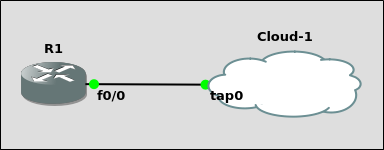

In [ ]:
'''
Following changes to configuration were made to make NETCONF work:
1. Changed the privilege level from 0 to 15.
2. Changed the IP address of R1 f0/0 interface from 198.51.10.1 to 198.51.100.1 so that it will be in same subnet as VM.
3. Removed access-groups from the interface.
4. Made the interface up.
5. Removed the static route for 198.51.100.0 network because the next hop was not present.
6. Removed both the access-lists that prevent connection to VM.
7. Configured SSH.
8. Changed ip ssh version from 1 to 2.
9. Configured Netconf over SSHv2.
10. Removed netconf max-message command.
'''

# Objective 4: NETCONF-YANG 

1. For this objective, we will use Cisco IOS XR router.
2. In VMWare, virtual machine settings, go to Hardware -> Processor -> Enable 'Intel VT-x/EPT or AMD-V/RVI' in Virtualization engine for KVM acceleration to work. 
3. Assign 4 GB RAM (if possible, assign 8 GB for Cisco IOS XR to boot up faster), go to Hardware -> Memory -> Memory for this virtual machine '4096 MB'.
4. Use Cisco XR router image installed in GNS3 for this objective. The router takes time to boot up. Note: Use username and password as netman and netman, respectively, along with IP address of Gi0/0/0/0 as 198.51.100.1

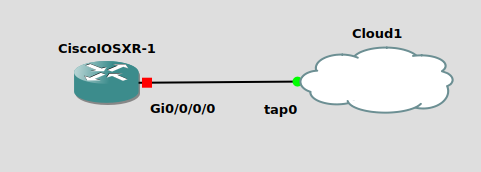

5. Enable NETCONF-YANG over SSH on the Cisco XR [https://www.cisco.com/c/en/us/support/docs/storage-networking/management/200933-YANG-NETCONF-Configuration-Validation.html#anc9]. Paste a screenshot of the output of ‘sh netconf-yang clients’, indicating a successful NETCONF connection [NC version should not be unknown]. [10 Points]

6. Use ncclient to complete the below objectives [https://ncclient.readthedocs.io/en/latest/] –
a. Change hostname of router to ‘Lab9_XR’,
b. Configure an access list on the router’s Gi0/0/0 interface to allow inbound traffic only from the host VM’s IP, and
c. Create a loopback interface and assign it an IP of 10.11.12.13/32.
Paste relevant screenshots of your script output. [15 Points]

In [1]:
from ncclient import manager

def obj4_config():
    
    m = manager.connect(host='198.51.100.1', port=22, username='netman', password='netman', hostkey_verify=False, allow_agent=False, look_for_keys=True, device_params={'name':'iosxr'})
    
    # change hostname
    hostname='''
        <config xmlns:xc="urn:ietf:params:xml:ns:netconf:base:1.0">
         <host-names xmlns="http://cisco.com/ns/yang/Cisco-IOS-XR-shellutil-cfg">
           <host-name>Lab8_XR</host-name>
         </host-names>
        </config>
        '''
    config_hostname = m.edit_config(hostname, target='candidate')
    print(config_hostname)
    config_hostname = m.commit()
    print(config_hostname)
    
    # configure ACL
    acl='''
        <config xmlns:xc="urn:ietf:params:xml:ns:netconf:base:1.0">
           <ipv4-acl-and-prefix-list xmlns="http://cisco.com/ns/yang/Cisco-IOS-XR-ipv4-acl-cfg">
            <accesses>
             <access>
              <access-list-name>acl_1</access-list-name>
               <access-list-entries>
                <access-list-entry>
                 <sequence-number>10</sequence-number>
                 <grant>permit</grant>
                 <source-network>
                  <source-address>198.51.100.2</source-address>
                  <source-wild-card-bits>0.0.0.255</source-wild-card-bits>
                 </source-network>
                 <sequence-str>10</sequence-str>
                </access-list-entry>
               </access-list-entries>
             </access>
            </accesses>
           </ipv4-acl-and-prefix-list>
           
          <interfaces xmlns="http://openconfig.net/yang/interfaces">
           <interface>
            <name>GigabitEthernet0/0/0/0</name>
            <config>
            <name>GigabitEthernet0/0/0/0</name>
            <type xmlns:idx="urn:ietf:params:xml:ns:yang:iana-if-type">idx:ethernetCsmacd</type>
            <enabled>true</enabled>
            </config>
            <ipv4-packet-filter xmlns="http://cisco.com/ns/yang/Cisco-IOS-XR-ip-pfilter-cfg">
             <inbound>
              <acl-name-array>acl_1</acl-name-array>
              <is-common-array>false</is-common-array>
             </inbound>
            </ipv4-packet-filter>
           </interface>
          </interfaces>
     </config>
        '''
    config_acl = m.edit_config(acl, target='candidate')
    print(config_acl)
    config_acl = m.commit()
    print(config_acl)


    # configure loopback
    loopback='''
    <config xmlns:xc="urn:ietf:params:xml:ns:netconf:base:1.0">
      <interfaces xmlns="http://openconfig.net/yang/interfaces">
       <interface>
        <name>Loopback1</name>
        <config>
         <name>Loopback1</name>
         <type xmlns:idx="urn:ietf:params:xml:ns:yang:iana-if-type">idx:softwareLoopback</type>
         <enabled>true</enabled>
        </config>
        <subinterfaces>
         <subinterface>
          <index>0</index>
          <ipv4 xmlns="http://openconfig.net/yang/interfaces/ip">
           <address>
            <ip>10.11.12.13</ip>
            <config>
             <ip>10.11.12.13</ip>
             <prefix-length>32</prefix-length>
            </config>
           </address>
          </ipv4>
         </subinterface>
        </subinterfaces>
       </interface>
      </interfaces>
    </config>
    '''

    config_loopback = m.edit_config(loopback, target='candidate')
    print(config_loopback)
    config_loopback = m.commit()
    print(config_loopback)

if __name__ == "__main__":
    obj4_config()

<?xml version="1.0"?>
<rpc-reply message-id="urn:uuid:8d085834-1477-4a1c-986f-f069164adb8d" xmlns:nc="urn:ietf:params:xml:ns:netconf:base:1.0" xmlns="urn:ietf:params:xml:ns:netconf:base:1.0">
 <ok/>
</rpc-reply>

<?xml version="1.0"?>
<rpc-reply message-id="urn:uuid:4a7f56ba-0c92-42c8-ab45-bb8c11a3714f" xmlns:nc="urn:ietf:params:xml:ns:netconf:base:1.0" xmlns="urn:ietf:params:xml:ns:netconf:base:1.0">
 <ok/>
</rpc-reply>

<?xml version="1.0"?>
<rpc-reply message-id="urn:uuid:cffc48a2-412a-4074-a6bb-51e768c746d9" xmlns:nc="urn:ietf:params:xml:ns:netconf:base:1.0" xmlns="urn:ietf:params:xml:ns:netconf:base:1.0">
 <ok/>
</rpc-reply>

<?xml version="1.0"?>
<rpc-reply message-id="urn:uuid:cac57fc1-3f82-41b4-9bd4-57b64b8b6880" xmlns:nc="urn:ietf:params:xml:ns:netconf:base:1.0" xmlns="urn:ietf:params:xml:ns:netconf:base:1.0">
 <ok/>
</rpc-reply>

<?xml version="1.0"?>
<rpc-reply message-id="urn:uuid:cbf375b3-9d8a-4c5b-8613-db98bd3a9923" xmlns:nc="urn:ietf:params:xml:ns:netconf:base:1.0" xmlns

In [ ]:
# Run the above method within main

if __name__ == "__main__"

# Objective 5 – Report Question [5 Points]

1. In your opinion, what are the advantages of using data models such as YANG or YAML in network automation?

2. Out of all the network automation tools you used (Netmiko, NAPALAM, Ansible, NETCONF, etc.), which one is your favorite and why?